# [Lab Session 4](deconvolution.ipynb)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

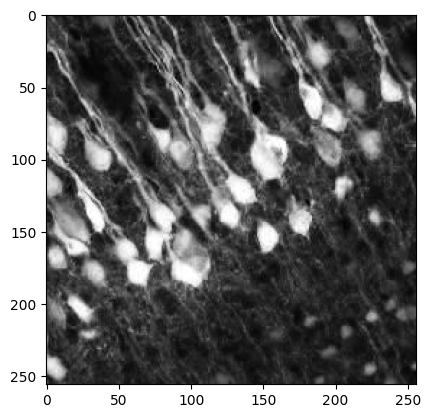

In [78]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

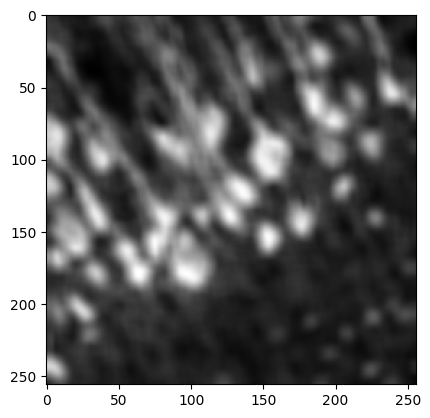

In [79]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2

PSF_img = conv(img, psf, mode = 'same', boundary = 'symm')
plt.imshow(PSF_img, 'gray')

#jedes Pixel wird zum Durchschnitt seiner Umgebung.

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

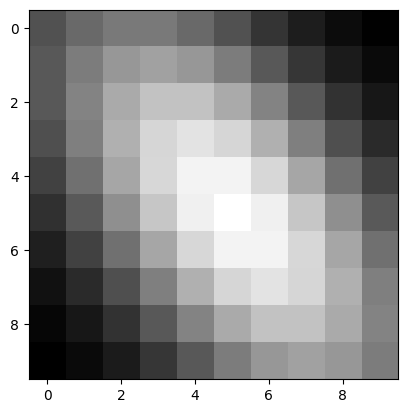

In [80]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

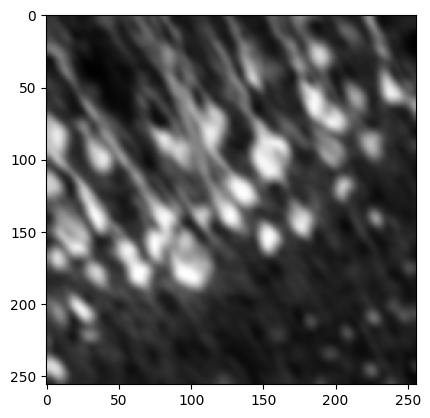

In [81]:
psf_gauss = create_psf(psf_size)
blurred_gauss = conv(img, psf_gauss, mode='same', boundary='symm')

plt.imshow(blurred_gauss, 'gray')

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [82]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    # Anfangsschätzung: konstantes Bild mit 0.5
    img_deconv = np.full(image.shape, 0.5)

    # PSF gespiegelt (180° Flip)
    psf_flipped = np.flip(psf)

    for _ in range(n_iterations):

        # Vorwärtsfaltung (Modell)
        conv_est = conv(img_deconv, psf, mode='same', boundary='symm')

        # Verhältnis g / (h*PSF)
        ratio = image / (conv_est + 1e-8)

        # Rückfaltung mit gespiegeltem PSF
        correction = conv(ratio, psf_flipped, mode='same', boundary='symm')

        # Update-Regel
        img_deconv = img_deconv * correction

    # Clipping in [0,1]
    img_deconv = img_deconv.clip(0, 1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

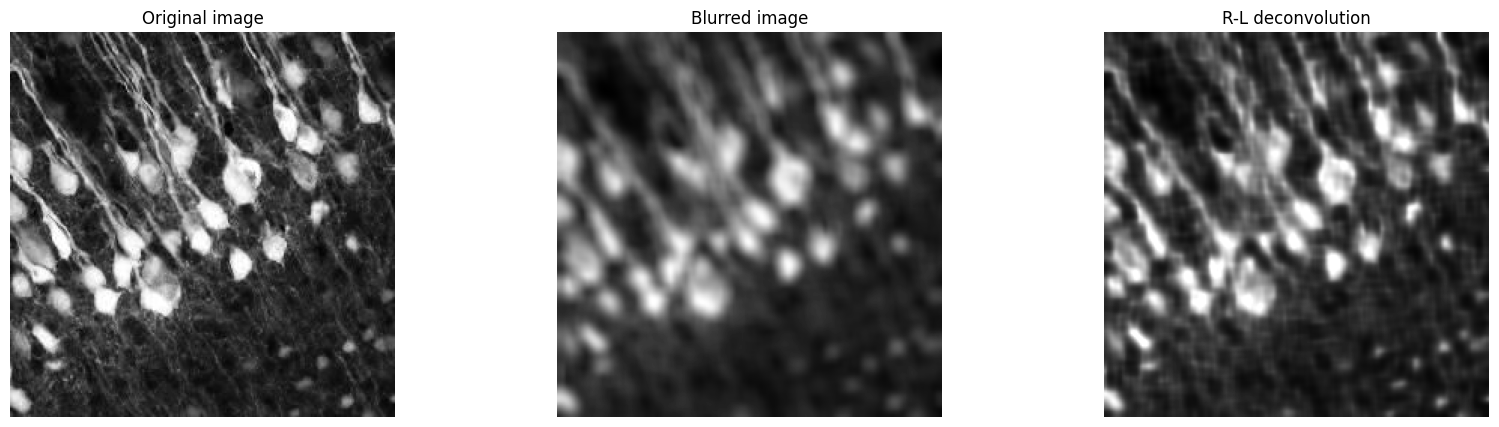

In [83]:
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(img, 'gray')
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(PSF_img, 'gray')
plt.title('Blurred image')
plt.subplot(1, 3, 3)
plt.axis('off')

restored_RL = richardson_lucy_deconvolution(PSF_img, psf, n_iterations = 30)
plt.imshow(restored_RL, 'gray')
plt.title('R-L deconvolution')
plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [84]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

noisy_img = np.clip(PSF_img + noise / reduce_factor, 0, 1)



(-0.5, 255.5, 255.5, -0.5)

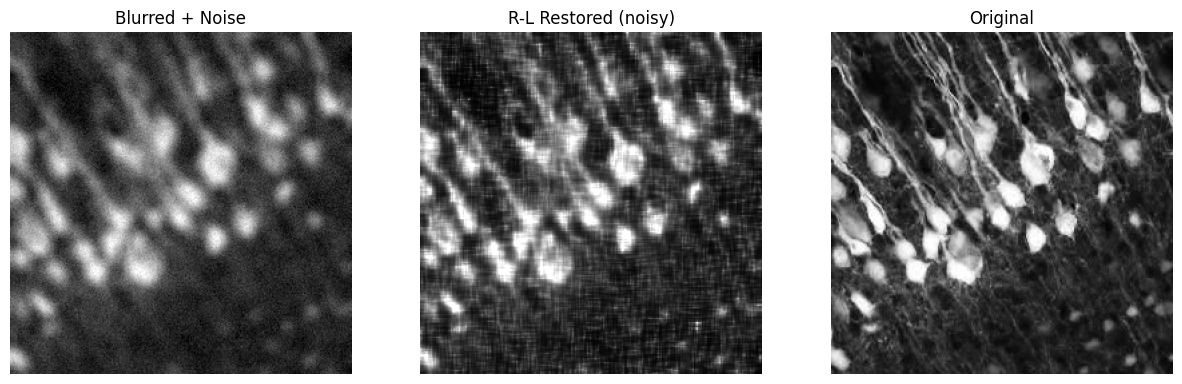

In [85]:
restored_noisy_RL = richardson_lucy_deconvolution(noisy_img, psf, n_iterations=30)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Blurred + Noise")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("R-L Restored (noisy)")
plt.imshow(restored_noisy_RL, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

#sehr empfindlich gegenüber Rauschen, da jeder kleine Fehler in den Iterationen verstärkt wird

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

(-0.5, 255.5, 255.5, -0.5)

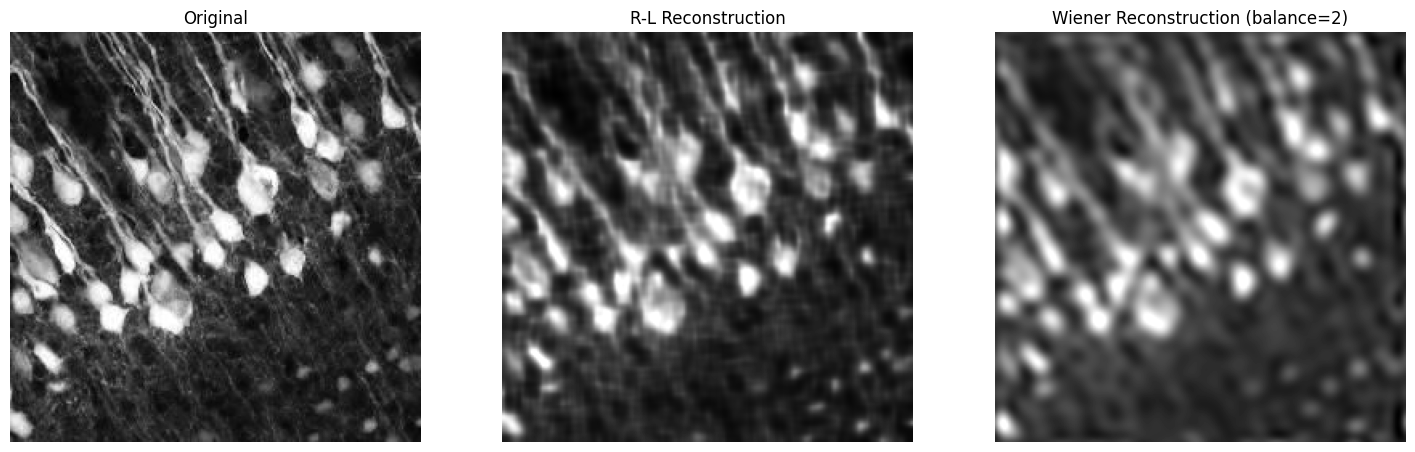

In [86]:
wiener_rec = wiener(PSF_img, psf, balance=2, clip=True)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("R-L Reconstruction")
plt.imshow(restored_RL, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Wiener Reconstruction (balance=2)")
plt.imshow(wiener_rec, cmap='gray')
plt.axis('off')

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

(-0.5, 255.5, 255.5, -0.5)

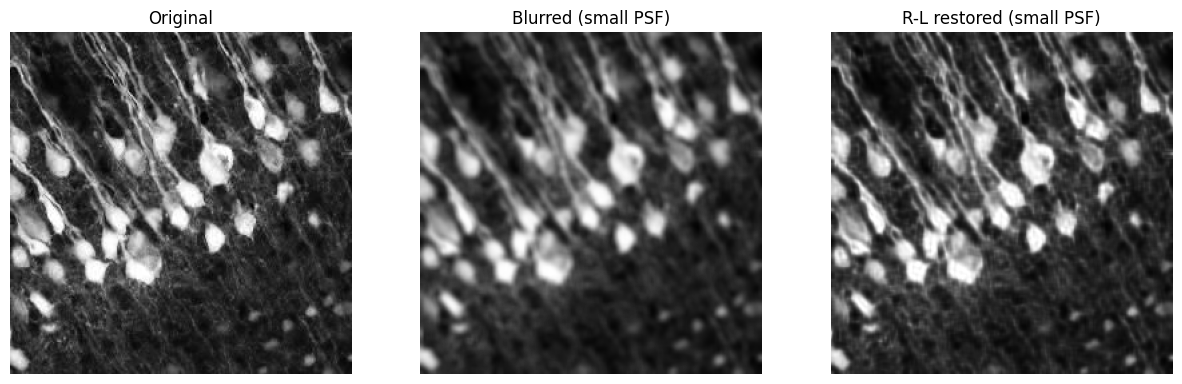

In [87]:
psf_small_size = 5
psf_small = np.ones((psf_small_size, psf_small_size)) / psf_small_size**2
PSF_img_small = conv(img, psf_small, mode='same', boundary='symm')
restored_small = richardson_lucy_deconvolution(PSF_img_small, psf_small, n_iterations=30)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Blurred (small PSF)")
plt.imshow(PSF_img_small, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("R-L restored (small PSF)")
plt.imshow(restored_small, cmap='gray')
plt.axis('off')


**[Task 8.]()** Use a wrong PSF to restore the image

(-0.5, 255.5, 255.5, -0.5)

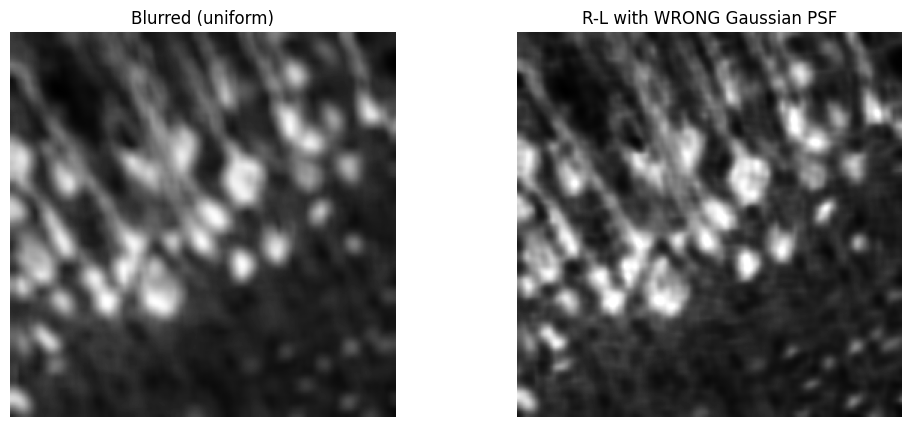

In [88]:
psf_gauss = create_psf(psf_size)

wrong_RL_1 = richardson_lucy_deconvolution(PSF_img, psf_gauss, n_iterations=30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Blurred (uniform)")
plt.imshow(PSF_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("R-L with WRONG Gaussian PSF")
plt.imshow(wrong_RL_1, cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

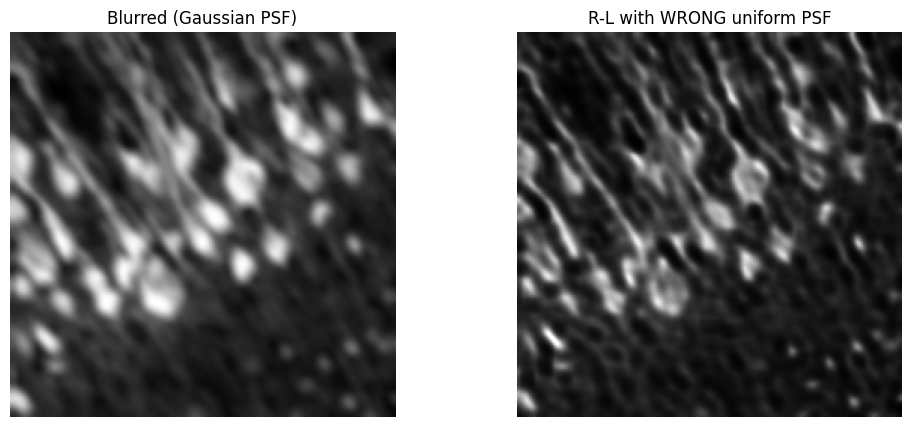

In [89]:
PSF_img_gauss = conv(img, psf_gauss, mode='same', boundary='symm')

wrong_RL_2 = richardson_lucy_deconvolution(PSF_img_gauss, psf, n_iterations=30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Blurred (Gaussian PSF)")
plt.imshow(PSF_img_gauss, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("R-L with WRONG uniform PSF")
plt.imshow(wrong_RL_2, cmap='gray')
plt.axis('off')